In [1]:
from zipline import run_algorithm
from zipline.api import (order_target_percent,symbol,set_commission,set_benchmark,order,record)
import numpy as np
from zipline.finance.commission import PerTrade
import pandas as pd
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline
from zipline.api import order_target, record, symbol, set_commission, set_slippage, set_long_only,order_target_percent
import warnings
import matplotlib.pyplot as plt
from zipline.utils.calendar_utils import get_calendar
# import talib
# from talib import MACD # type: ignore
warnings.filterwarnings('ignore')
warnings.filterwarnings('always')
import sys
import os
root_dir = os.getcwd().replace('/Notebooks','')
sys.path.insert(1, root_dir)
from zipline.utils.run_algo import load_extensions
from utils.utils import *
from logbook import (NestedSetup, NullHandler, Logger, StreamHandler, StderrHandler, INFO, WARNING, DEBUG, ERROR)
import pytz
load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)

/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [2]:
%matplotlib inline 
%load_ext zipline
%load_ext autoreload
%autoreload 2

In [3]:
calendar_name = '24/7'
calendar = get_calendar(calendar_name)

## MACD Crossover Strategy
 This strategy involves buying when the MACD line crosses above the signal line, and selling when the MACD line crosses below the signal line. This is a popular and simple strategy that can work well in trending markets.

In [4]:
def initialize(context):
    context.asset = symbol('BTC')
    context.i = 0
    context.short_span = 2
    context.long_span = 7
    context.signal_span = 5

def handle_data(context, data):
    context.i += 1
    if context.i < context.long_span:
        return
    prices = data.history(context.asset, 'close', context.long_span, '1d')
    ema12 = prices.ewm(span= context.short_span, adjust= False).mean()
    ema26 = prices.ewm(span= context.long_span, adjust= False).mean()
    macd = ema12 - ema26
    signal = macd.ewm(span= context.signal_span, adjust= False).mean()
    hist = macd - signal
    if macd[-1] > signal[-1] and macd[-2] <= signal[-2]:
        order_target_percent(context.asset, 80)
    elif macd[-1] < signal[-1] and macd[-2] >= signal[-2]:
        order(context.asset, 0)
    

    record(macd=macd[-1], signal=signal[-1], price=data.current(context.asset, 'price'))

In [9]:
start_date = pd.to_datetime('2020-1-1', utc= True, format = '%Y-%m-%d %H:%M')
end_date = pd.to_datetime('2021-1-1', utc= True, format = '%Y-%m-%d %H:%M')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='cryptocompare_daily',
                            data_frequency='daily',
                            )

NotSessionError: Parameter `session_label` takes a session label although received input that parsed to '2003-04-06 00:00:00+00:00' which is earlier than the first session of calendar '24/7' ('2003-04-09 00:00:00+00:00').

In [ ]:
# results.tail()

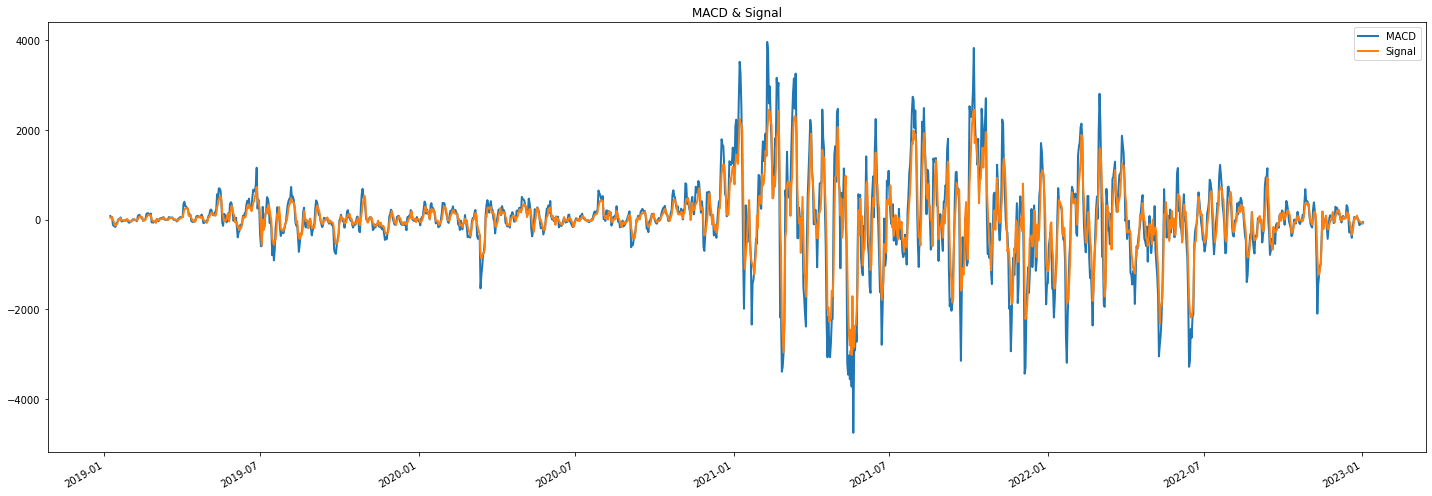

In [ ]:
results.macd.plot(figsize=(20, 7), title='MACD & Signal' , lw=2, label='MACD')
results.signal.plot(figsize=(20, 7), lw=2, label='Signal')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

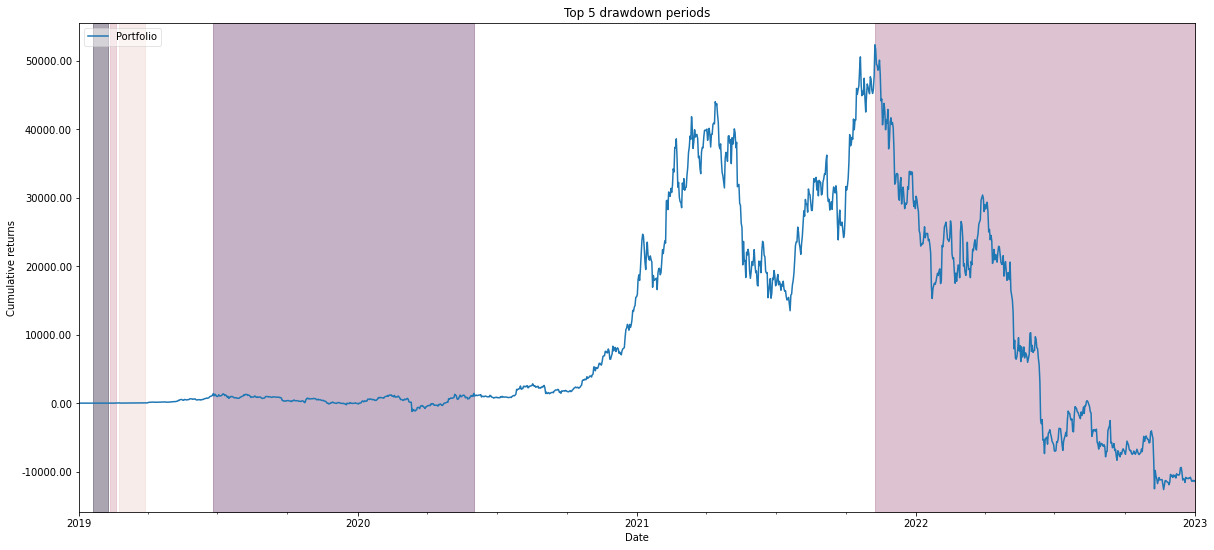

In [ ]:
plt.figure(figsize=(20, 9))
pf.plot_drawdown_periods(returns, top=5).set_xlabel('Date')
plt.show()

In [ ]:
sharpe = results['sharpe'].dropna()
portfolio_value = results['portfolio_value'].dropna()
algo_vola = results['algo_volatility'].dropna()

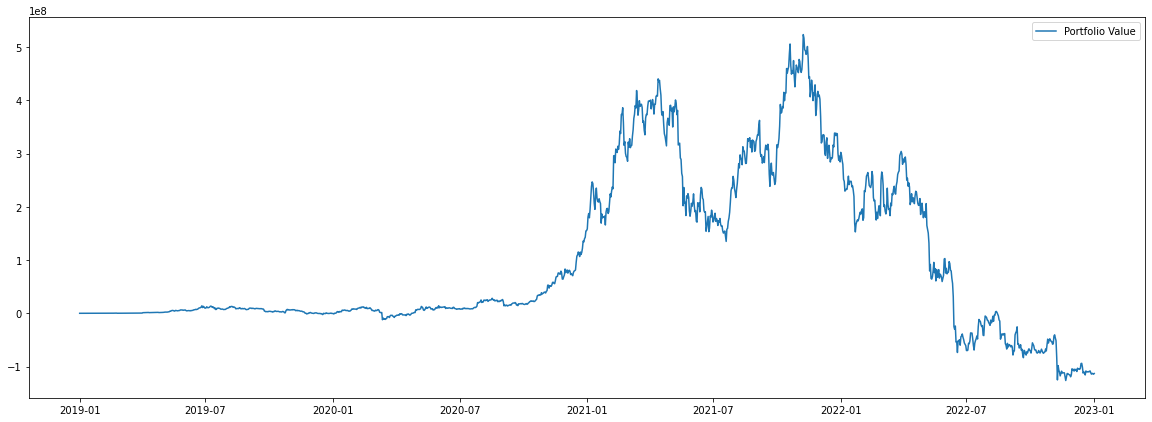

In [ ]:
plt.figure(figsize= (20, 7))
plt.plot(portfolio_value)
plt.legend(['Portfolio Value'])
plt.show()

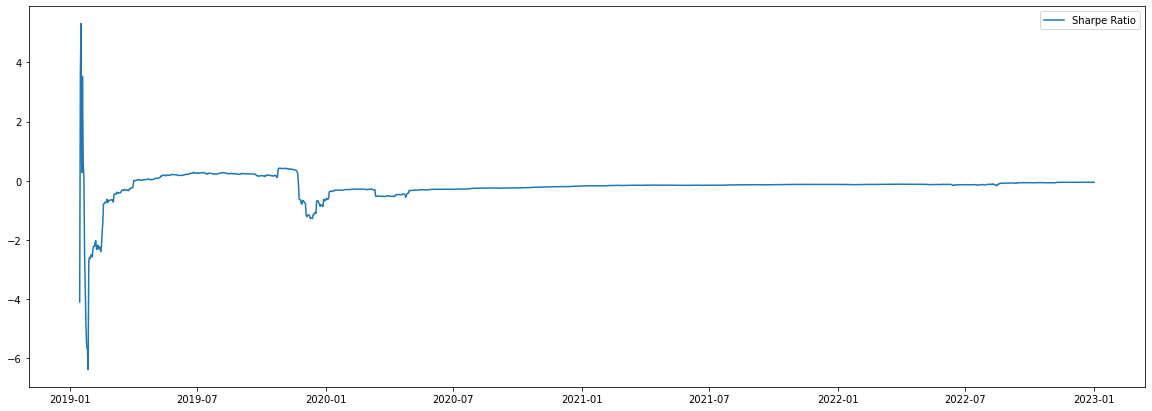

In [ ]:
plt.figure(figsize= (20, 7))
plt.plot(sharpe)
plt.legend(['Sharpe Ratio'])

plt.show()

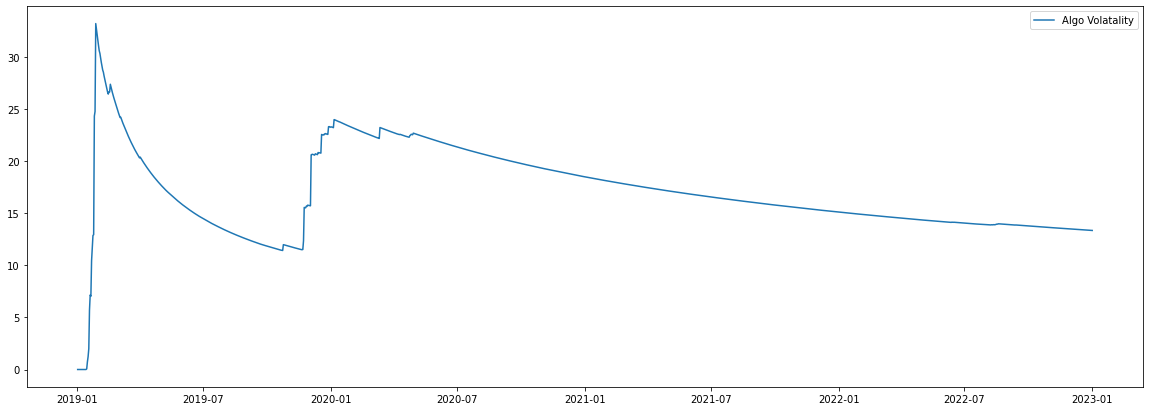

In [ ]:
plt.figure(figsize= (20, 7))
plt.plot(algo_vola)
plt.legend(['Algo Volatality'])
plt.show()

/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/timeseries.py:734: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:446: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:446: RuntimeWarning: inval

Start date,2019-01-01
End date,2023-01-01
Total months,69
,Backtest
Annual return,nan%
Cumulative returns,-1478023.996%
Annual volatility,2439.537%
Sharpe ratio,0.20
Calmar ratio,NaN
Stability,NaN
Max drawdown,-429.746%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,429.75,2019-01-19,2019-02-07,2019-02-08,15
1,189.82,2019-06-26,2020-03-12,2020-06-01,244
2,119.93,2021-11-08,2022-11-21,NaT,NaN
3,74.06,2019-02-23,2019-03-04,2019-03-20,18
4,72.40,2019-02-10,2019-02-14,2019-02-18,6


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.versio

Stress Events,mean,min,max
New Normal,1.96%,-1171.15%,4748.35%


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Top 10 long positions of all time,max
sid,
BTC,97309.96%


Top 10 short positions of all time,max
sid,
BTC,-121281.80%


Top 10 positions of all time,max
sid,
BTC,121281.80%


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/round_trips.py:331: FutureWarning: The frame.append met

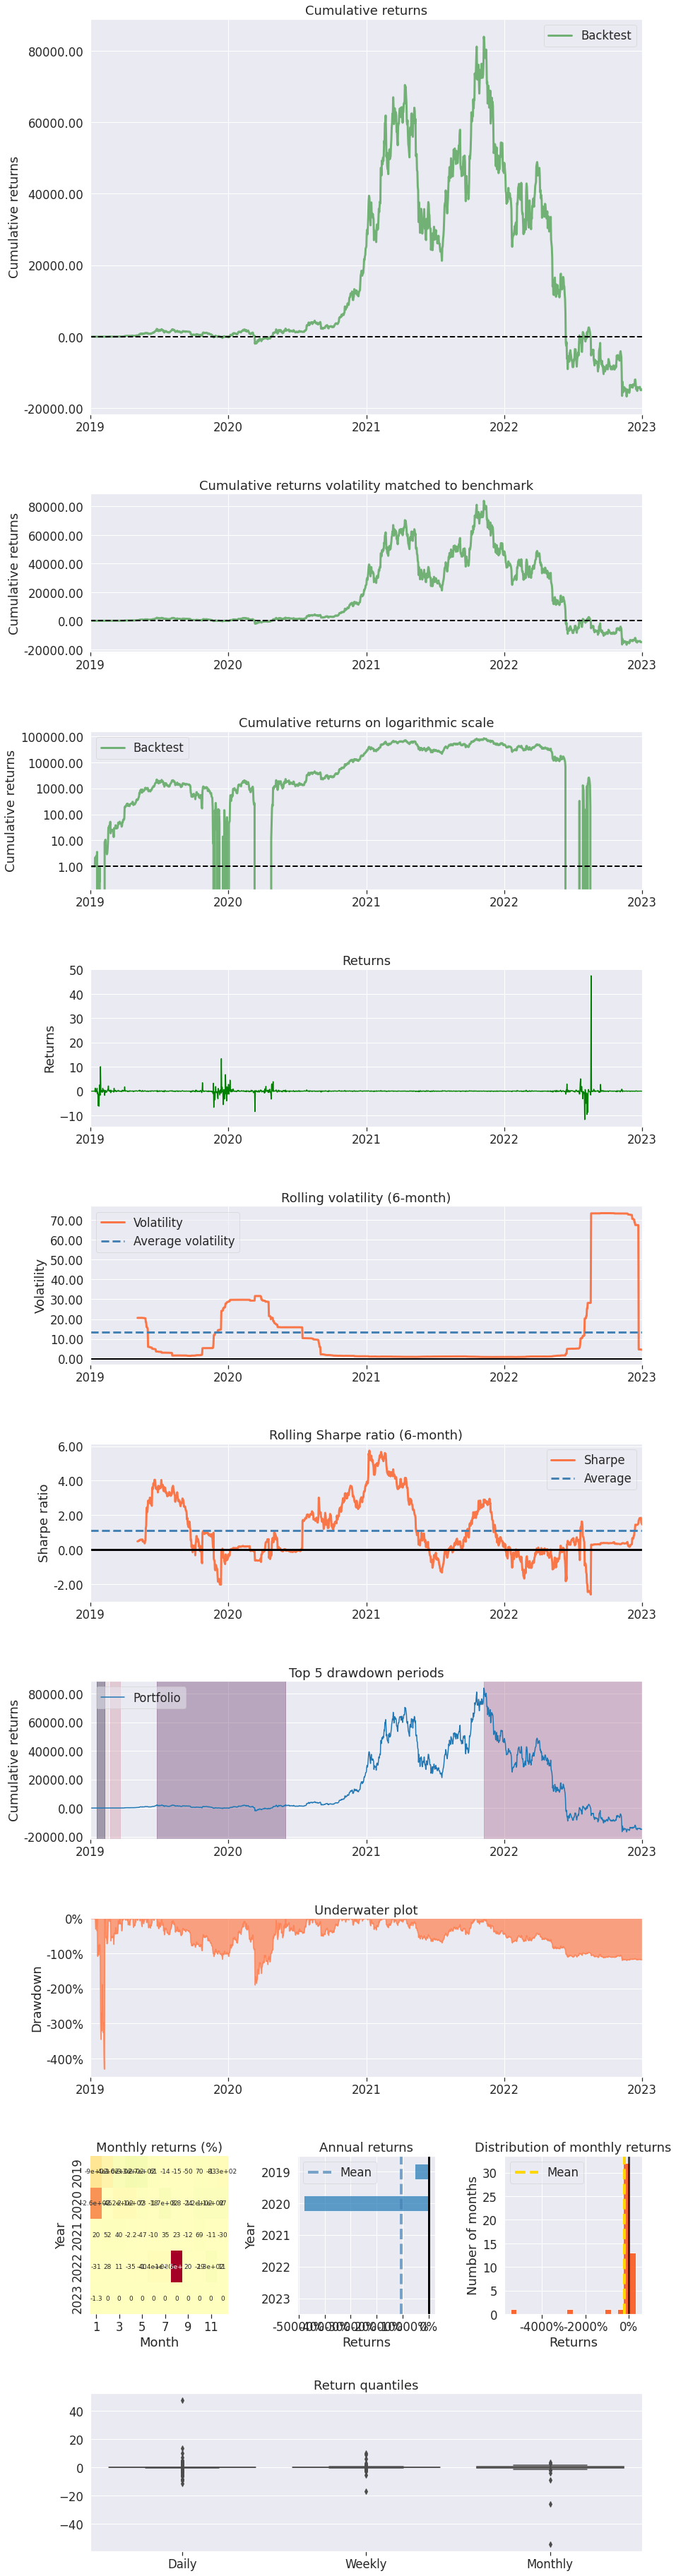

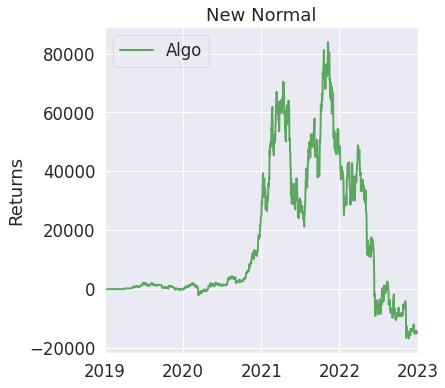

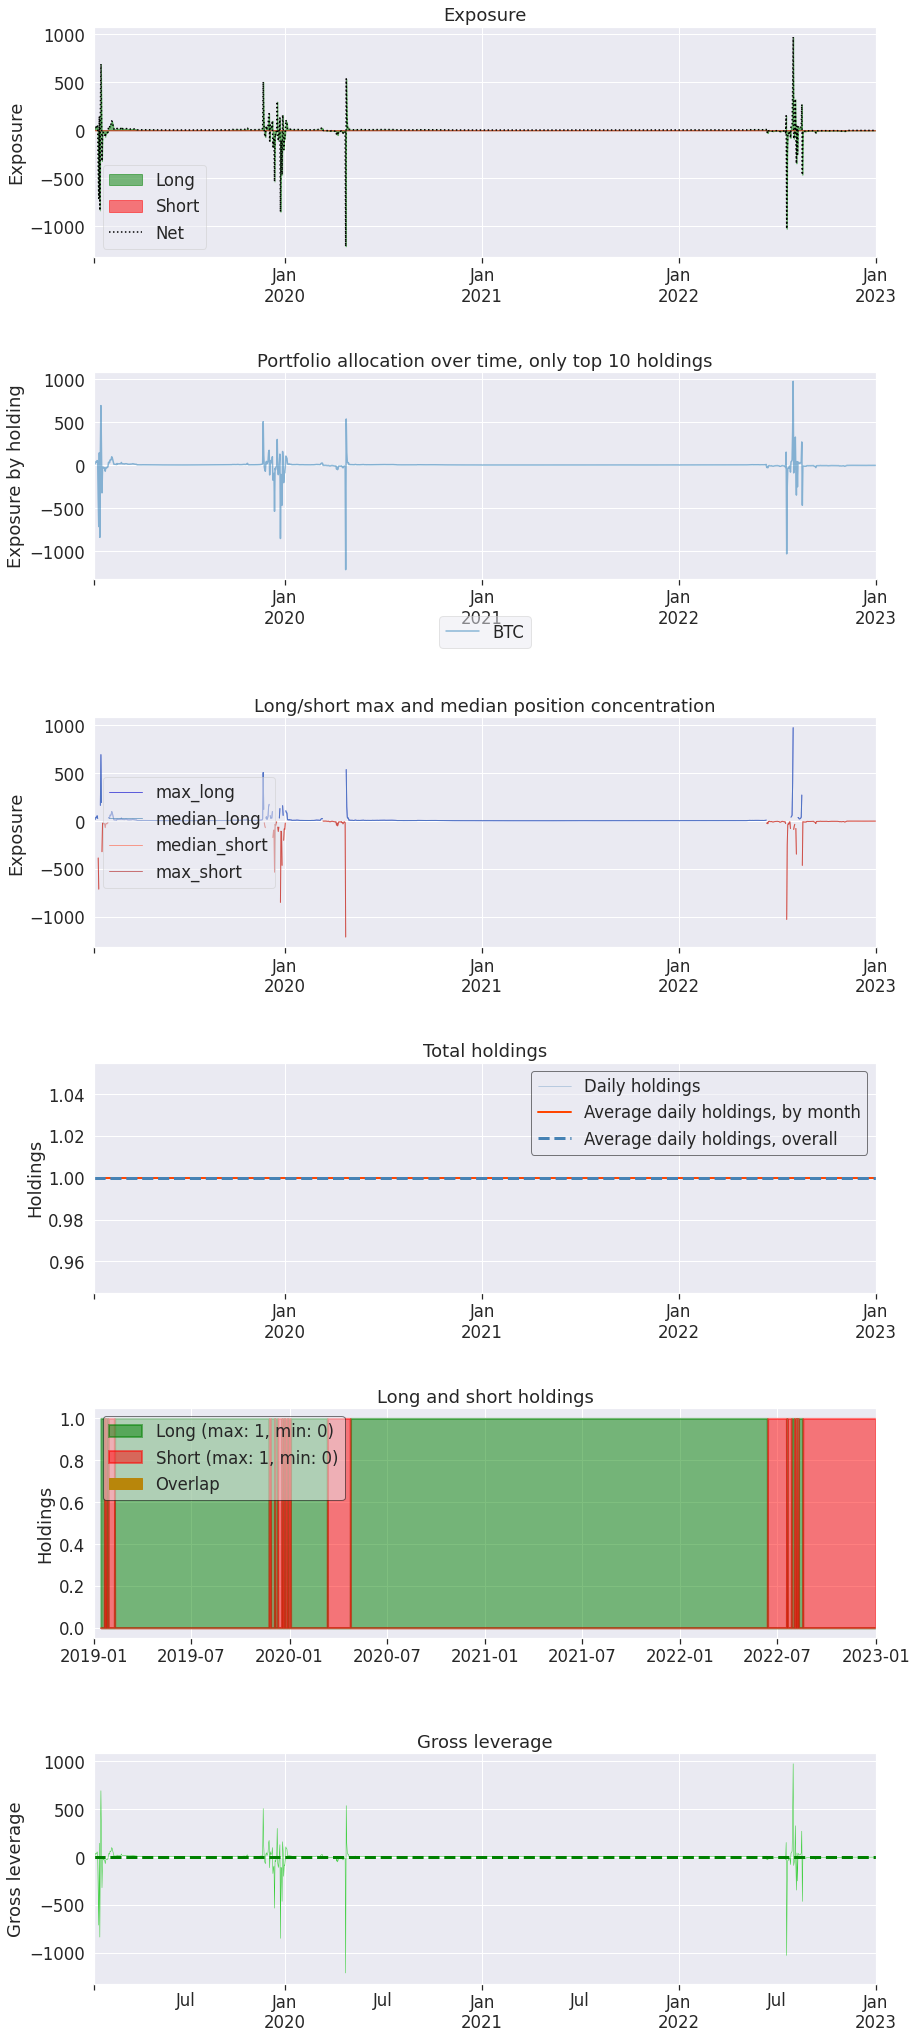

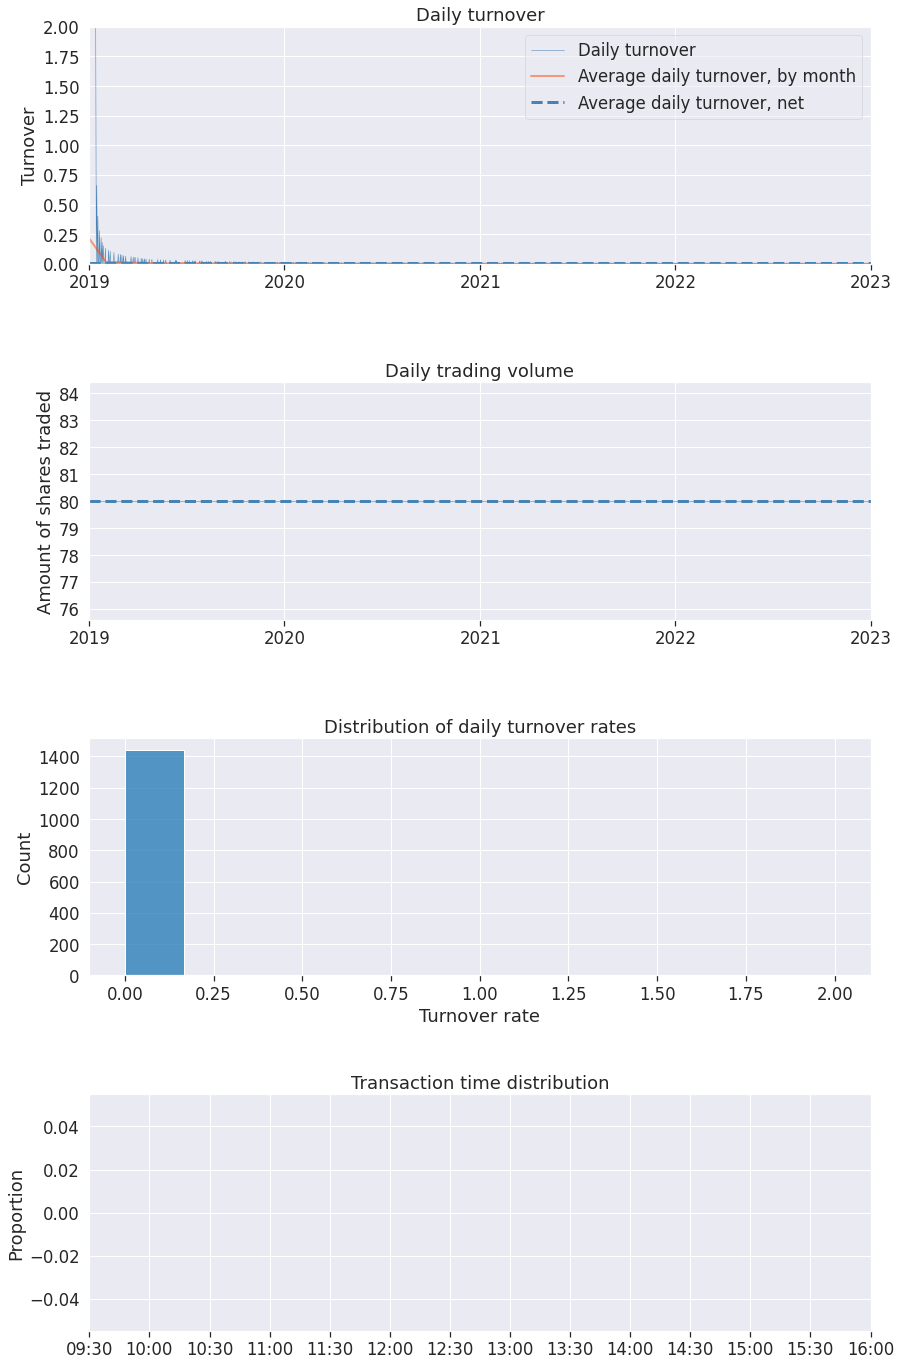

In [ ]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, round_trips=True)

## MACD Divergence Strategy

In MACD divergence trading, we look for situations where the MACD line and the price of the asset are moving in opposite directions, indicating a potential change in trend. This is known as bearish divergence if the price is making higher highs while the MACD line is making lower highs, and bullish divergence if the price is making lower lows while the MACD line is making higher lows.

In [ ]:
def initialize(context):
    context.asset = symbol('BTC')
    context.i = 0
    context.short_span = 12
    context.long_span = 26
    context.signal_span = 9
    # set_long_only()


def handle_data(context, data):
    context.i += 1
    if context.i <= context.short_span:
        return
    
    prices = data.history(context.asset, 'close', context.long_span, '1d')
    ema12 = prices.ewm(span= context.short_span, adjust= False).mean()
    ema26 = prices.ewm(span= context.long_span, adjust= False).mean()
    macd = ema12 - ema26
    macdsignal = macd.ewm(span= context.signal_span, adjust= False).mean()
    
    
    if macd[-1] > macdsignal[-1] and macd[-2] < macdsignal[-2] and prices[-1] > prices[-2]:
        order_target(context.asset, 100)
    elif macd[-1] < macdsignal[-1] and macd[-2] > macdsignal[-2] and prices[-1] < prices[-2]:
        order_target(context.asset, -100)

    record(price=prices[-1], macd=macd[-1], signal=macdsignal[-1])

start_date = pd.to_datetime('2019-1-1', utc= True, format = '%Y-%m-%d %H:%M')
end_date = pd.to_datetime('2023-1-1', utc= True, format = '%Y-%m-%d %H:%M')
results = run_algorithm(start=start_date,
                            end=end_date,
                            initialize=initialize,
                            handle_data=handle_data,
                            capital_base=10000,
                            benchmark_returns=None,
                            trading_calendar=calendar,
                            bundle='cryptocompare_daily',
                            data_frequency='daily',
                            )


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:706: RuntimeWarning: invalid value encountered in true_divide
  np.divide(
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:797: RuntimeWarning: invalid value encounte

In [ ]:
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)

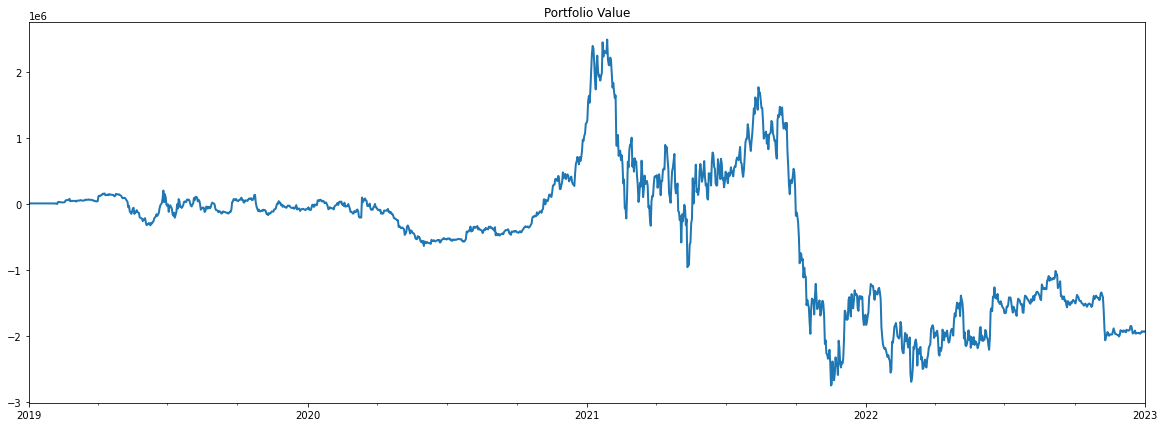

In [ ]:
results.portfolio_value.plot(figsize=(20, 7), title='Portfolio Value' , lw=2, label='Portfolio Value')
plt.show()

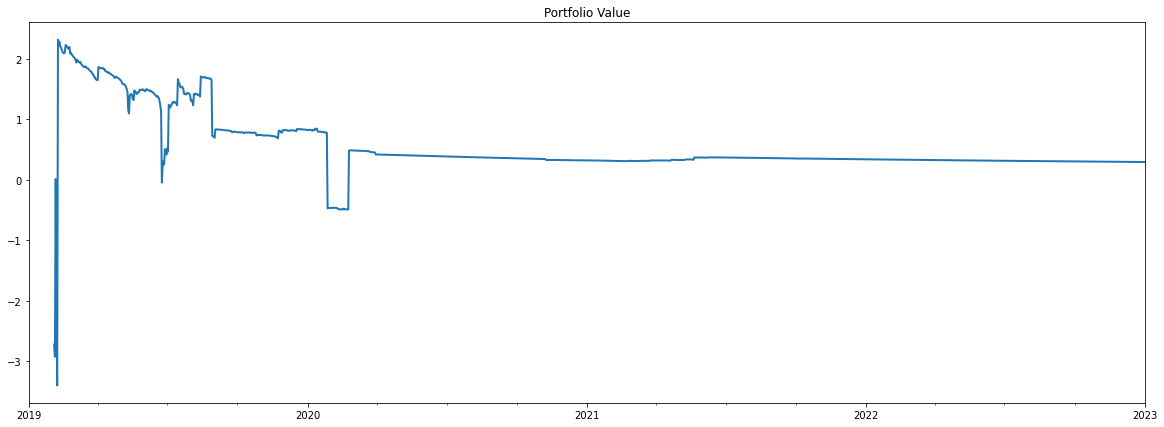

In [ ]:
results.sharpe.plot(figsize=(20, 7), title='Portfolio Value' , lw=2, label='Portfolio Value')
plt.show()

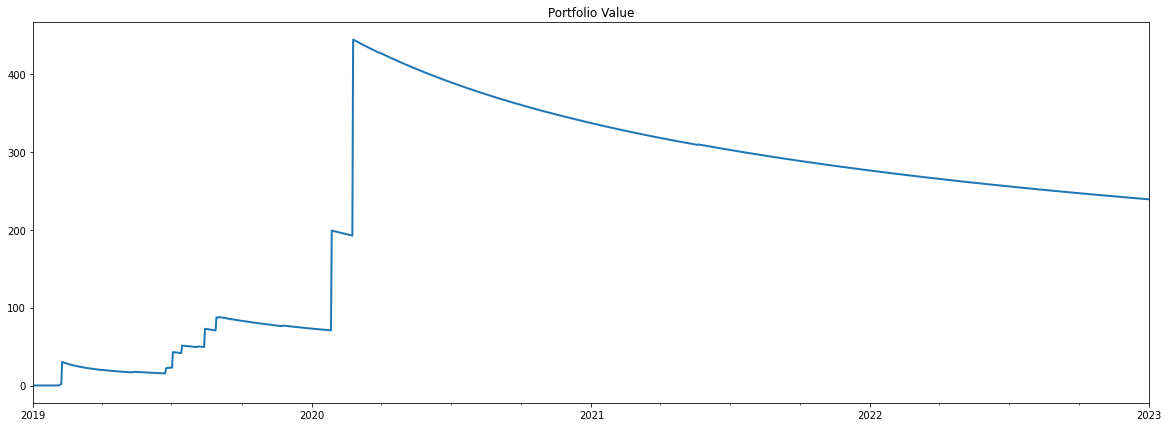

In [ ]:
results.algo_volatility.plot(figsize=(20, 7), title='Portfolio Value' , lw=2, label='Portfolio Value')
plt.show()

/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/timeseries.py:734: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:446: RuntimeWarning: invalid value encountered in double_scalars
  return ending_value ** (1 / num_years) - 1
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/empyrical/stats.py:446: RuntimeWarning: inval

Start date,2019-01-01
End date,2023-01-01
Total months,69
,Backtest
Annual return,nan%
Cumulative returns,-19406.448%
Annual volatility,23881.722%
Sharpe ratio,0.29
Calmar ratio,NaN
Stability,NaN
Max drawdown,-410.226%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,410.23,2019-06-26,2020-06-01,2020-11-17,365
1,300.73,2019-04-10,2019-06-09,2019-06-26,56
2,210.29,2021-01-27,2021-11-16,NaT,NaN
3,76.02,2019-02-02,2019-02-07,2019-02-08,5
4,52.37,2019-02-23,2019-03-04,2019-04-02,27


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/plotting.py:835: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.versio

Stress Events,mean,min,max
New Normal,27.89%,-23145.48%,51607.48%


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Top 10 long positions of all time,max
sid,
BTC,212741.29%


Top 10 short positions of all time,max
sid,
BTC,-1644127.87%


Top 10 positions of all time,max
sid,
BTC,1644127.87%


/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/faruk/miniconda3/envs/fa/lib/python3.9/site-packages/pyfolio/round_trips.py:331: FutureWarning: The frame.append met

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,68.00,34.00,34.00
Percent profitable,0.46,0.47,0.44
Winning round_trips,31.00,16.00,15.00
Losing round_trips,37.00,18.00,19.00
Even round_trips,0.00,0.00,0.00


PnL stats,All trades,Short trades,Long trades
Total profit,$-1940631.32,$-1628441.92,$-312189.40
Gross profit,$10242104.43,$5408980.33,$4833124.11
Gross loss,$-12182735.75,$-7037422.24,$-5145313.51
Profit factor,$0.84,$0.77,$0.94
Avg. trade net profit,$-28538.70,$-47895.35,$-9182.04
Avg. winning trade,$330390.47,$338061.27,$322208.27
Avg. losing trade,$-329263.13,$-390967.90,$-270805.97
Ratio Avg. Win:Avg. Loss,$1.00,$0.86,$1.19
Largest winning trade,$1655556.64,$1316116.43,$1655556.64
Largest losing trade,$-2628347.44,$-2628347.44,$-818983.82


Duration stats,All trades,Short trades,Long trades
Avg duration,20 days 23:38:50.308823529,21 days 08:28:15.911764706,20 days 14:49:24.705882353
Median duration,18 days 00:00:00,19 days 12:00:00,17 days 00:00:00
Longest duration,98 days 00:00:00,62 days 00:00:00,98 days 00:00:00
Shortest duration,1 days 00:00:00,3 days 00:00:00,1 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,2.11%,-22.42%,26.63%
Avg returns winning,75.39%,77.12%,74.22%
Avg returns losing,-116.28%,-121.95%,-105.56%
Median returns all round_trips,9.43%,0.53%,20.26%
Median returns winning,36.39%,26.75%,38.41%
Median returns losing,-37.84%,-42.47%,-13.79%
Largest winning trade,745.02%,388.75%,745.02%
Largest losing trade,-736.88%,-654.02%,-736.88%


Symbol stats,BTC
Avg returns all round_trips,2.11%
Avg returns winning,75.39%
Avg returns losing,-116.28%
Median returns all round_trips,9.43%
Median returns winning,36.39%
Median returns losing,-37.84%
Largest winning trade,745.02%
Largest losing trade,-736.88%


Profitability (PnL / PnL total) per name,
symbol,
BTC,100.00%


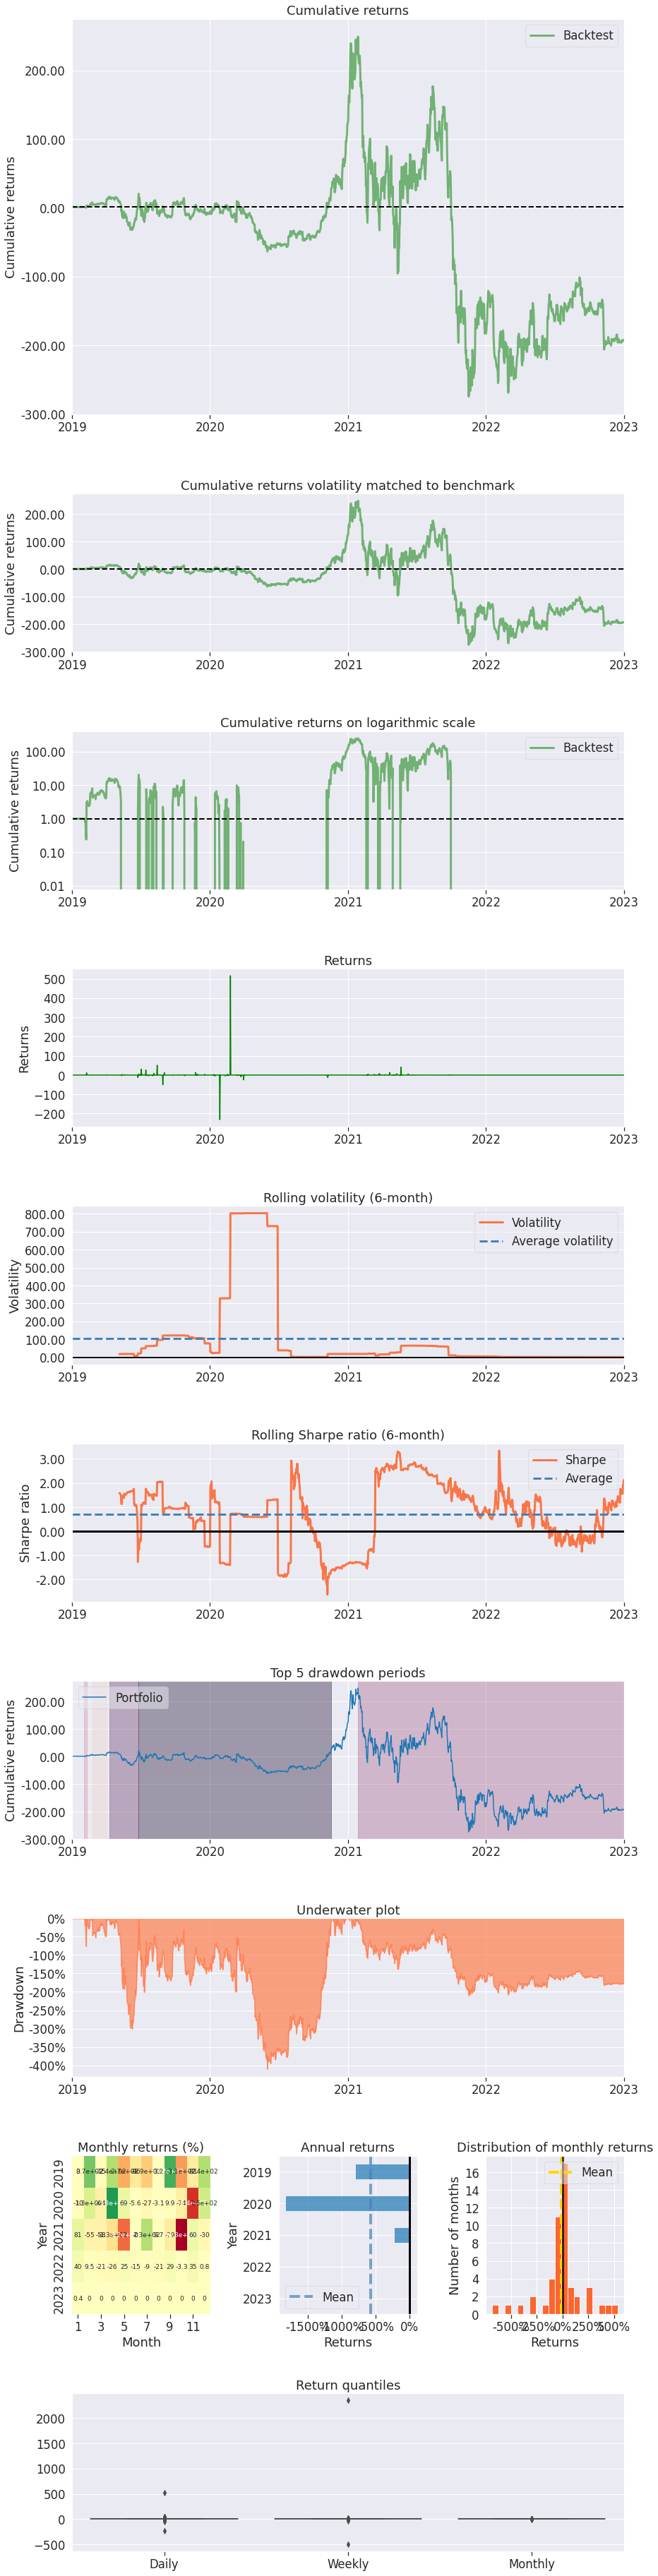

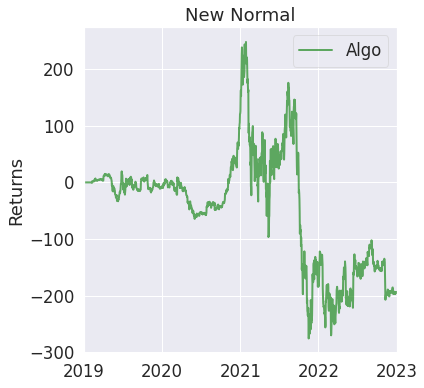

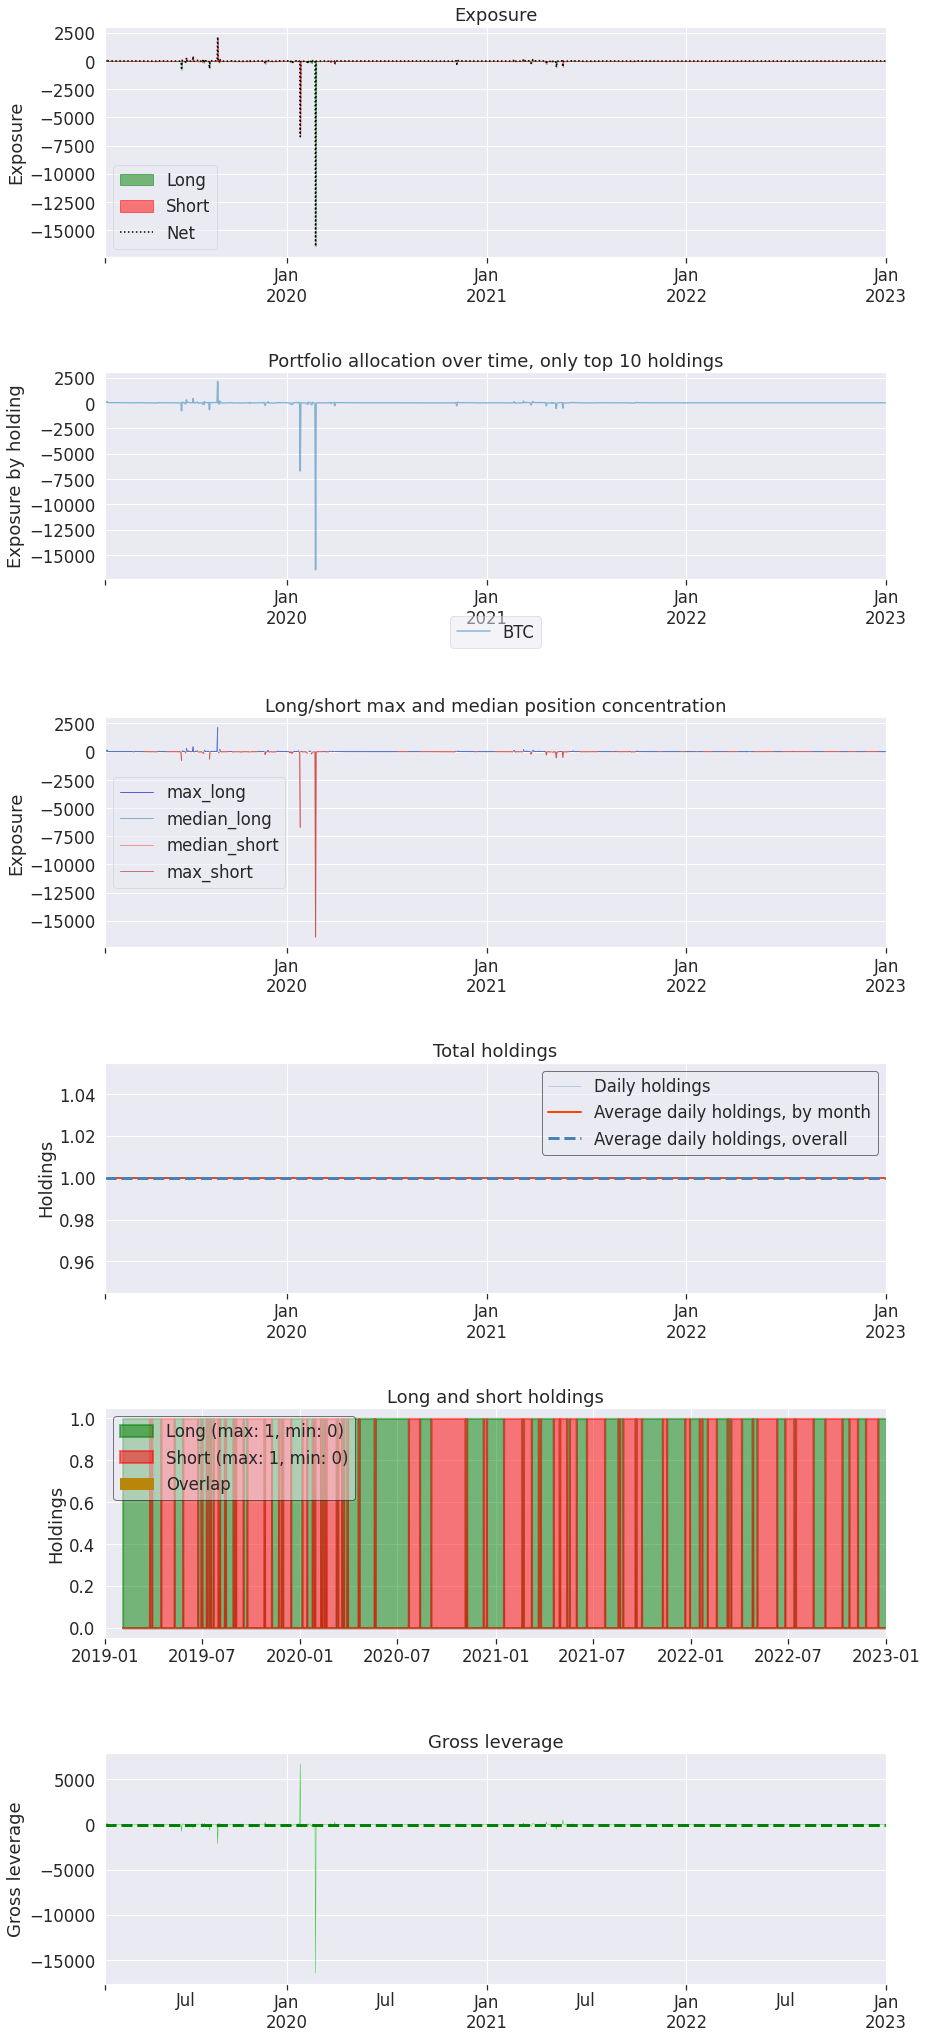

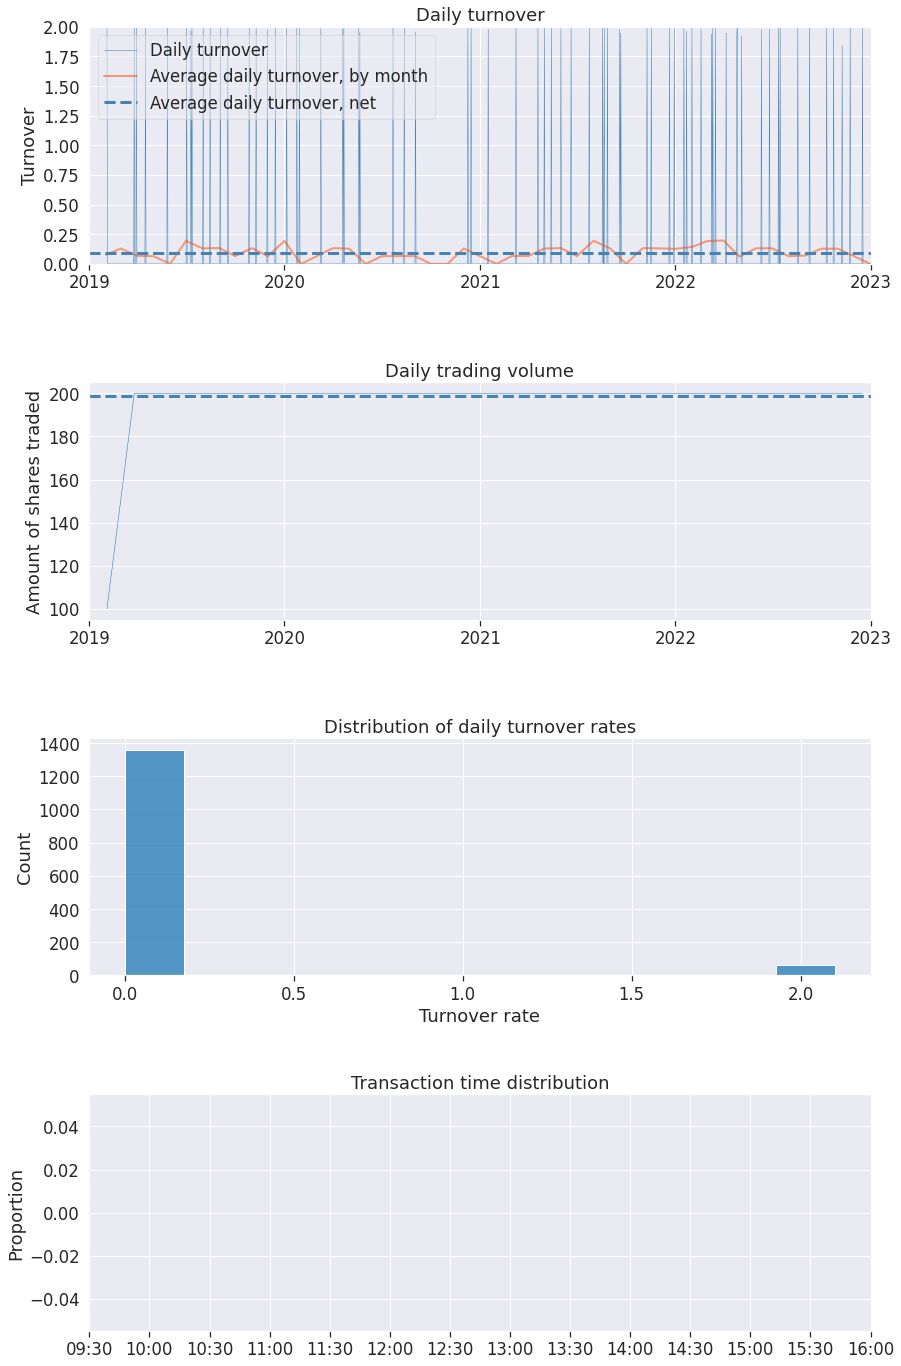

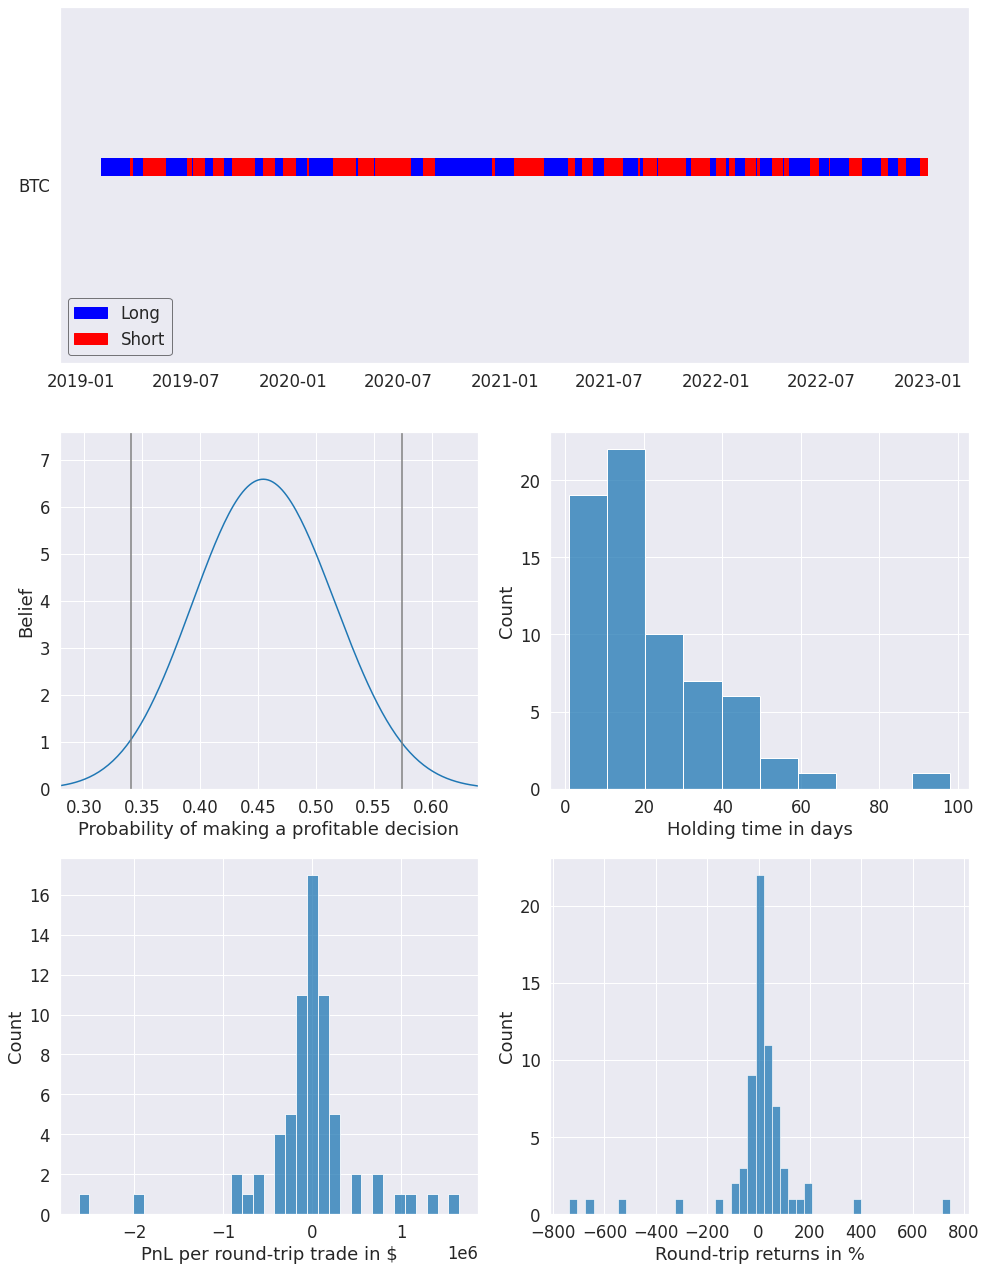

In [ ]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, round_trips=True)